In [1]:
import numpy as np
# import awkward
import logging
logging.basicConfig(level=logging.INFO, format='[%(asctime)s] %(levelname)s: %(message)s')
import numpy as np
import scipy.optimize as opt
import sys, os, random, gzip
import tensorflow as tf
from keras import backend as K
from keras.models import *
from keras.layers import *
from keras.optimizers import Adam
from keras.losses import categorical_crossentropy
import keras
import pandas as pd



In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import h5py
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D
from sklearn.model_selection import train_test_split
import sys
from sklearn import metrics
from keras.models import load_model
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import auc as skAUC
from keras.callbacks import EarlyStopping, ModelCheckpoint, CSVLogger, TensorBoard
import tensorflow as tf
from keras import backend as K
import time
import glob
from tqdm import tqdm
from sklearn.metrics import roc_curve, auc

# Prepare ParticleNet data

## 1.Read the h5py file and show the keys you use

In [ ]:
f = h5py.File("/home/ja2006203966/script/Network/data/H5/SVJ/rinv03/"+str(0)+"Trimjetc.h5",'r')
f.keys()

## 2.Define the function you need

In [ ]:
##------------calculate jet constituents energy, if you already had this information don't use it.
def jce_np(jcpt, jceta, jcmass):
    jcp = jcpt*np.cosh(jceta)
    return (jcp**2+jcmass**2)**0.5


#-------- attach integers to your keys  this example is : 'index' -> 0-th data, 'JCPT' ->1-th data
# and 'index' is event index
# 'JCPT' is constituents transvers momentum (PT)
# 'JCETA' is constituents ETA
# 'JCPHI' is constituents angle around beam axis
# 'Ncontituents' is Number of constituents in the jet which the constitunt belong
# 'constiteunts_index' is constituents index in each jet ('constiteunts' is typo)
# 'JCDELTAETA' is constituents ETA related to jet axis
# 'JCDELTAPHI' is constituents ETA related to jet axis
# 'PT' is transvers momentum (PT) of jet which which the constitunt belong
# 'ETA' is ETA of jet which which the constitunt belong
# 'PHi' is PHI of jet which which the constitunt belong


_index, _jcpt, _jceta, _jcphi, _jcmass, _Ncons, _consindex, _jcdelteta, _jcdeltphi, _jpt, _jeta, _jphi = (i for i in range(12))
Labels = ['index', 'JCPT', 'JCETA', 'JCPHI', 'JCMASS', 'Ncontiteunts', 'constiteunts_index', 'JCDELTETA', 'JCDELTPHI', 'PT', 'ETA', 'PHI']

##--------------------------------------------------h5py file to ParticleNet input structure
def h5_to_data(h5path):
    Data = {'mask':[], 'points':[], 'features':[]}
    f = h5py.File(h5path,'r')
    fc = np.array([f[lb][()] for lb in Labels])
    fc = fc.transpose((1,0))
    j0 = fc[0][_index]
    
    JCE = jce_np(fc[:,_jcpt], fc[:,_jceta], fc[:,_jcphi])
    logpt = np.log(fc[:,_jcpt])
    loge = np.log(JCE)
    relatpt = fc[:,_jcpt]/fc[:,_jpt]
    mask, features, points = np.zeros((100,1)), np.zeros((100,5)), np.zeros((100,2)) # prepare constituents list
    Nfc = len(fc)
    for j in range(len(fc)):
        if fc[j][_Ncons]>100:
            if j< Nfc-1:
                j0 = fc[j+1][_index]
            continue
        if fc[j][_index]!=j0:
            j0 = fc[j][_index]
            Data['mask'].append(mask)
            Data['points'].append(points)
            Data['features'].append(features)
            mask, features, points = np.zeros((100,1)), np.zeros((100,5)), np.zeros((100,2)) # prepare constituents list
            continue
        jc = int(fc[j][_consindex])
#         jce = JCE[j]
        
        points[jc] = np.array([fc[j][_jcdelteta], fc[j][_jcdeltphi] ])
        mask[jc] = logpt[j]
        features[jc] = np.array([logpt[j], loge[j], fc[j][_jcdelteta], fc[j][_jcdeltphi], relatpt[j]])
    return Data

##==========================================================================================
##----------merging 2 sample with ParticleNet input structure
def merging(gg,qq):
    total={}
    total['mask']=gg["mask"]+qq["mask"]
    total['features']=gg["features"]+qq["features"]
    total['points']=gg['points']+qq['points']
    return total
##--------- seperate inputs to training, validation and testing with ratio you give
def separatedata(features_list,y,rateval,ratetest):
    features_train, features_test, features_val={},{},{}
    from sklearn.model_selection import train_test_split
    mask = features_list["mask"]
    features = features_list["features"]
    points = features_list["points"]
    X_ind = [i for i in range(len(y))]
    X_train, X_ind, y_train, y_ind = train_test_split(X_ind, y, test_size=rateval+ratetest)
    N=int(len(X_ind)*rateval/(rateval+ratetest))
    X_val, X_test = X_ind[:N], X_ind[N:]
    y_val, y_test = y_ind[:N], y_ind[N:]
    features_train['mask']=np.array([mask[i] for i in X_train])
    features_train['features']=np.array([features[i] for i in X_train])
    features_train['points']=np.array([points[i] for i in X_train])
    
    features_test['mask']=np.array([mask[i] for i in X_test])
    features_test['features']=np.array([features[i] for i in X_test])
    features_test['points']=np.array([points[i] for i in X_test])
    
    features_val['mask']=np.array([mask[i] for i in X_val])
    features_val['features']=np.array([features[i] for i in X_val])
    features_val['points']=np.array([points[i] for i in X_val])
    
    return features_train, features_val, features_test,np.array(y_train), np.array(y_val), np.array(y_test) 
    

## 3.Loop all data you generated and check input shape

In [18]:
N=40
Jim = np.array([np.zeros((64,64))])
Data = {'mask':[], 'points':[], 'features':[]}
Data2 =  {'mask':[], 'points':[], 'features':[]}
for i in tqdm(range(N)):
    h5path1 = "/home/ja2006203966/script/Network/data/H5/SVJ/rinv03/"+str(i)+"Trimjetc.h5"
    h5path2 = "/home/ja2006203966/script/Network/data/H5/QCD/"+str(i)+"Trimjetc.h5"
    data = h5_to_data(h5path1)
    data2 = h5_to_data(h5path2)
    Data = merging(Data, data)
    Data2 = merging(Data2, data2)


100%|██████████| 40/40 [04:17<00:00,  6.44s/it]


In [19]:
print("check shape: ",Data['mask'][0].shape,Data['points'][0].shape,Data['features'][0].shape)

check shape:  (100, 1) (100, 2) (100, 5)


## 4.Prepare the target (Note if you want to use N classification you need to change y dimension, and YOU NEED TO CHANGE THE OUTPUT LAYER SHAPE)

In [ ]:
## for 3 classification example
## y = [[0,0,1] for i in range(len(Data['mask']))]+[[0,1,0] for i in range(len(Data2['mask']))] +[[1,0,0] for i in range(len(Data2['mask']))] 


## binary calssification: 
y=[[0,1] for i in range(len(Data['mask']))]+[[1,0] for i in range(len(Data2['mask']))] 
total = merging(Data, Data2)
# del gg, qq, eventg, eventq
# del Data, Data2
X_train, X_val, X_test, y_train, y_val, y_test = separatedata(total,y,0.3,0.1)

In [ ]:
## check the shape
print([X_train[i][0].shape for i in lb])

## 5.Save the training data

In [ ]:
outfile = "/home/ja2006203966/script/Network/data/H5/ParticleNet/Train.h5"
hf = h5py.File(outfile, 'r')
lb = ['mask', 'points', 'features']
X_train, X_val, X_test ={'mask':[], 'points':[], 'features':[]},{'mask':[], 'points':[], 'features':[]},{'mask':[], 'points':[], 'features':[]}
for i in lb:
    X_train[i] = hf["X_train_"+i][()]
    X_val[i] = hf["X_val_"+i][()]
    X_test[i] = hf["X_test_"+i][()]


y_train = hf["y_train"][()]
y_val = hf["y_val"][()]
y_test = hf["y_test"][()]

hf.close()

# ParticleNet

## 1.import your model

In [ ]:
from tf_keras_model import get_particle_net

## 2.Setup your ParticleNet

In [ ]:
# input_shapes={'points': Data['points'][0].shape, 'features': Data['features'][0].shape, 'mask': Data['mask'][0].shape}
input_shapes={'points': X_train['points'][0].shape, 'features': X_train['features'][0].shape, 'mask': X_train['mask'][0].shape}

num_classes = 2
## This is my modification of ParticleNet
# w = 0 ## weights you can choose (it is added by myself, and I use the 5-th as the weight term)
# model = get_particle_net(num_classes, input_shapes, w=w, K=16)

## This is my ParticleNet
model = get_particle_net(num_classes, input_shapes)

In [ ]:
# Training parameters
batch_size = 200
epochs = 200

## 3.Summary

In [11]:
model.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])
# optimizer=keras.optimizers.Adam(learning_rate=lr_schedule(0))
model.summary()

Model: "ParticleNet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
features (InputLayer)           [(None, 100, 5)]     0                                            
__________________________________________________________________________________________________
mask (InputLayer)               [(None, 100, 1)]     0                                            
__________________________________________________________________________________________________
tf_op_layer_ExpandDims (TensorF [(None, 100, 1, 5)]  0           features[0][0]                   
__________________________________________________________________________________________________
tf_op_layer_NotEqual (TensorFlo [(None, 100, 1)]     0           mask[0][0]                       
________________________________________________________________________________________

## 4.Training

In [26]:
# train_dataset.shuffle()
model.fit(X_train ,y_train,
          batch_size=batch_size,
          epochs=epochs, 
          validation_data=(X_val, y_val),
          shuffle=True ,
          callbacks=callbacks)
model.evaluate(X_test,  y_test, verbose=2)

Epoch 1/200
2138/2138 [==============================] - ETA: 0s - loss: 0.4561 - accuracy: 0.7851

[2020-08-04 10:05:25,404] WARNING: Can save best model only with val_acc available, skipping.


2138/2138 [==============================] - 433s 202ms/step - loss: 0.4561 - accuracy: 0.7851 - val_loss: 0.4342 - val_accuracy: 0.7971
Epoch 2/200
2138/2138 [==============================] - ETA: 0s - loss: 0.4226 - accuracy: 0.8063

[2020-08-04 10:12:38,009] WARNING: Can save best model only with val_acc available, skipping.


2138/2138 [==============================] - 432s 202ms/step - loss: 0.4226 - accuracy: 0.8063 - val_loss: 0.4265 - val_accuracy: 0.8022
Epoch 3/200
2138/2138 [==============================] - ETA: 0s - loss: 0.4104 - accuracy: 0.8132

[2020-08-04 10:19:50,169] WARNING: Can save best model only with val_acc available, skipping.


2138/2138 [==============================] - 432s 202ms/step - loss: 0.4104 - accuracy: 0.8132 - val_loss: 0.4809 - val_accuracy: 0.7839
Epoch 4/200
2138/2138 [==============================] - ETA: 0s - loss: 0.4045 - accuracy: 0.8169

[2020-08-04 10:27:02,084] WARNING: Can save best model only with val_acc available, skipping.


2138/2138 [==============================] - 432s 202ms/step - loss: 0.4045 - accuracy: 0.8169 - val_loss: 0.4142 - val_accuracy: 0.8109
Epoch 5/200
2138/2138 [==============================] - ETA: 0s - loss: 0.3999 - accuracy: 0.8194

[2020-08-04 10:34:13,816] WARNING: Can save best model only with val_acc available, skipping.


2138/2138 [==============================] - 432s 202ms/step - loss: 0.3999 - accuracy: 0.8194 - val_loss: 0.4046 - val_accuracy: 0.8168
Epoch 6/200
2138/2138 [==============================] - ETA: 0s - loss: 0.3972 - accuracy: 0.8210

[2020-08-04 10:41:25,378] WARNING: Can save best model only with val_acc available, skipping.


2138/2138 [==============================] - 431s 202ms/step - loss: 0.3972 - accuracy: 0.8210 - val_loss: 0.3938 - val_accuracy: 0.8238
Epoch 7/200
2138/2138 [==============================] - ETA: 0s - loss: 0.3953 - accuracy: 0.8220

[2020-08-04 10:48:36,942] WARNING: Can save best model only with val_acc available, skipping.


2138/2138 [==============================] - 431s 202ms/step - loss: 0.3953 - accuracy: 0.8220 - val_loss: 0.3989 - val_accuracy: 0.8196
Epoch 8/200
2138/2138 [==============================] - ETA: 0s - loss: 0.3931 - accuracy: 0.8240

[2020-08-04 10:55:48,517] WARNING: Can save best model only with val_acc available, skipping.


2138/2138 [==============================] - 431s 202ms/step - loss: 0.3931 - accuracy: 0.8240 - val_loss: 0.3926 - val_accuracy: 0.8238
Epoch 9/200
2138/2138 [==============================] - ETA: 0s - loss: 0.3916 - accuracy: 0.8245

[2020-08-04 11:03:00,027] WARNING: Can save best model only with val_acc available, skipping.


2138/2138 [==============================] - 431s 202ms/step - loss: 0.3916 - accuracy: 0.8245 - val_loss: 0.3972 - val_accuracy: 0.8213
Epoch 10/200
2138/2138 [==============================] - ETA: 0s - loss: 0.3905 - accuracy: 0.8251

[2020-08-04 11:10:11,369] WARNING: Can save best model only with val_acc available, skipping.


2138/2138 [==============================] - 431s 202ms/step - loss: 0.3905 - accuracy: 0.8251 - val_loss: 0.4209 - val_accuracy: 0.8095
Epoch 11/200
2138/2138 [==============================] - ETA: 0s - loss: 0.3888 - accuracy: 0.8261

[2020-08-04 11:17:22,866] WARNING: Can save best model only with val_acc available, skipping.


2138/2138 [==============================] - 431s 202ms/step - loss: 0.3888 - accuracy: 0.8261 - val_loss: 0.3899 - val_accuracy: 0.8255
Epoch 12/200
2138/2138 [==============================] - ETA: 0s - loss: 0.3879 - accuracy: 0.8271

[2020-08-04 11:24:34,052] WARNING: Can save best model only with val_acc available, skipping.


2138/2138 [==============================] - 431s 202ms/step - loss: 0.3879 - accuracy: 0.8271 - val_loss: 0.4186 - val_accuracy: 0.8118
Epoch 13/200
2138/2138 [==============================] - ETA: 0s - loss: 0.3869 - accuracy: 0.8270

[2020-08-04 11:31:44,197] WARNING: Can save best model only with val_acc available, skipping.


2138/2138 [==============================] - 430s 201ms/step - loss: 0.3869 - accuracy: 0.8270 - val_loss: 0.3904 - val_accuracy: 0.8248
Epoch 14/200
2138/2138 [==============================] - ETA: 0s - loss: 0.3862 - accuracy: 0.8277

[2020-08-04 11:38:54,800] WARNING: Can save best model only with val_acc available, skipping.


Restoring model weights from the end of the best epoch.
2138/2138 [==============================] - 430s 201ms/step - loss: 0.3862 - accuracy: 0.8277 - val_loss: 0.3931 - val_accuracy: 0.8239
Epoch 00014: early stopping
2227/2227 - 41s - loss: 0.3892 - accuracy: 0.8245


[0.38920512795448303, 0.8244606852531433]

In [28]:
model.save('./H5/ParticleNet/ParticleNet_f.h5')

# ROC and Learing curve 

## 1.Import package and load training history

In [27]:
from sklearn.metrics import roc_curve, auc
import pandas as pd
import csv
import matplotlib.pyplot as plt
import pickle

In [41]:
LOSS0 = pd.read_csv('./myparticlenet_training_log.csv')
# label = []
# for i in LOSS0:
#     label.append(i)


## 2.Plot ROC curve

The area under the curves are:
AUC:0.902108526


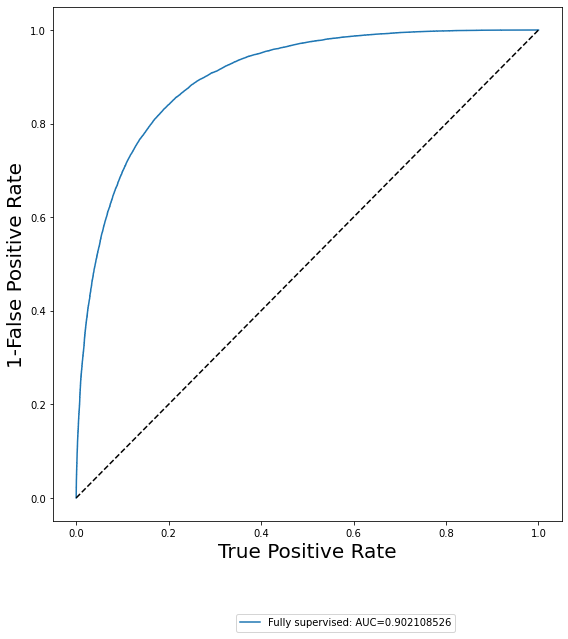

In [29]:
y_score=model.predict(X_test)[:,0]
test=[i[1] for i in y_test]
fpr , tpr , thresholds = roc_curve ( test , y_score)
roc_auc = auc(tpr,fpr )
print("The area under the curves are:")
print("AUC:{0:.9f}".format(roc_auc))
# FalsePositiveFull, TruePositiveFull, ThresholdFull = metrics.roc_curve(y_test,Predictions)
plt.figure(figsize=(8,16))
plt.subplot(2,1,1)

plt.plot(tpr,fpr, label='Fully supervised: AUC={0:.9f}'.format(roc_auc))
plt.ylabel('1-False Positive Rate',fontsize=20)
plt.xlabel('True Positive Rate',fontsize=20)
plt.plot([0, 1], [0, 1], 'k--')
plt.legend(bbox_to_anchor=(0.8, -0.17),ncol=2)
plt.tight_layout()
plt.savefig("./H5/ParticleNet/Myneighnorhood_Particlenet_roc.png")
hf = h5py.File("/home/ja2006203966/script/Network/data/H5/ParticleNet/PR.h5", 'w')
hf.create_dataset('fpr', data=fpr)
hf.create_dataset('tpr', data=tpr)
hf.close()

plt.show()

## 3.Plot learning curve

In [ ]:
plt.figure(figsize=(8,8))
LOSS = pd.read_csv(save_dir)
# LOSS = pd.read_csv("/home/ja2006203966/script/Network/data/myparticlenet_training_log.csv")

plt.title("Learning Curve")
plt.plot(LOSS["loss"], label='loss',c='blue')
plt.plot(LOSS["val_loss"], label='val_loss',c='red')
plt.plot(LOSS["accuracy"], linestyle='--', label='accuracy',c='blue')
plt.plot(LOSS["val_accuracy"], linestyle='--', label='val_accuracy',c='red')
# plt.ylim([0.3,1])
plt.ylabel('loss',fontsize=20)
plt.xlabel('epoch',fontsize=20)
# plt.legend(bbox_to_anchor=(0.8, -0.17),ncol=2)
plt.legend(bbox_to_anchor=(0.8, -0.17),ncol=2)
plt.tight_layout()
plt.savefig("/home/ja2006203966/script/Network/data/H5/ParticleNet/ParticleNetloss.png")

plt.show()